In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-classification/Plaksha_Faculty.jpg
/kaggle/input/dataset-classification/Dr_Shashi_Tharoor.jpg


In [2]:
!pip install numpy pandas scikit-learn wandb

In [3]:
import wandb
wandb.login(key="75d5588f2aa6d1c45c80a50a6173cb9e0bb8134f")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sandeep-l-ug23 (sandeep-l-ug23-plaksha). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
run = wandb.init(project="distance_classification_project", name="face_clustering")

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

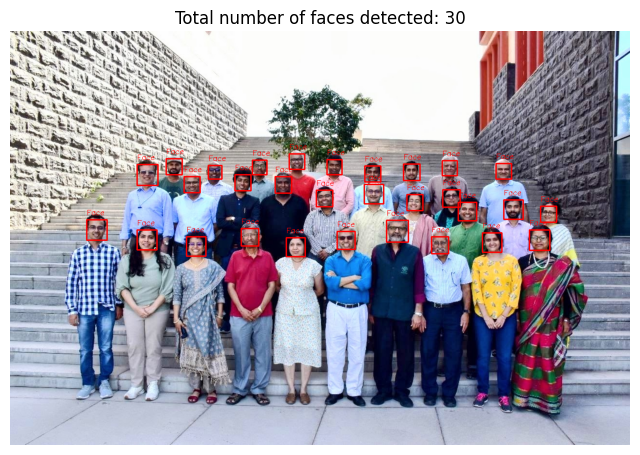

In [8]:
# Reading the image
img = cv2.imread("/kaggle/input/dataset-classification/Plaksha_Faculty.jpg")  # Load the image
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

# Loading the required Haar-cascade classifier file
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Applying face detection
faces_rect = face_cascade.detectMultiScale(gray_img, 1.05, 4, minSize=(25, 25), maxSize=(50, 50))

# Define text and font parameters
text = "Face"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_color = (0, 0, 255)  # Red color
font_thickness = 1

# Draw rectangles around detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(img, text, (x, y - 10), font, font_scale, font_color, font_thickness)

# Convert BGR (OpenCV) to RGB (matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using plt
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Total number of faces detected: {len(faces_rect)}")
plt.show()

output_path = "detected_faces.png"
cv2.imwrite(output_path, img)

# Log findings to wandb
wandb.log({"Detected Faces": len(faces_rect)})
wandb.log({"Face Detection Image": wandb.Image(output_path)})


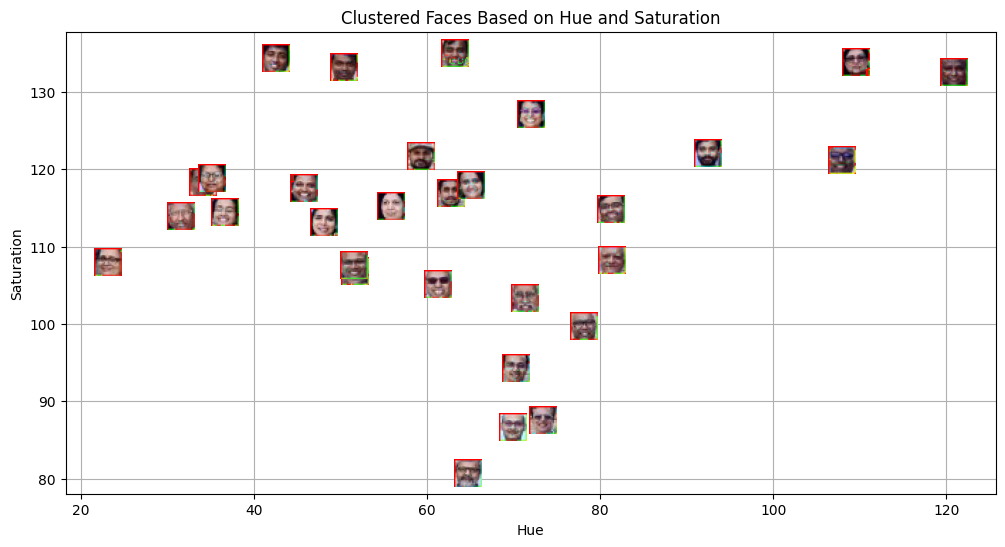

In [9]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  

hue_saturation = []
face_images = []  # To store detected face images

# Extract face region features (Hue and Saturation)
for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

# Perform k-Means clustering on hue_saturation
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(hue_saturation)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x, y, w, h) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, 
             color='red' if kmeans.labels_[i] == 0 else 'blue')

# Labels and title
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Clustered Faces Based on Hue and Saturation")
plt.grid(True)

# Show the plot
plt.show()

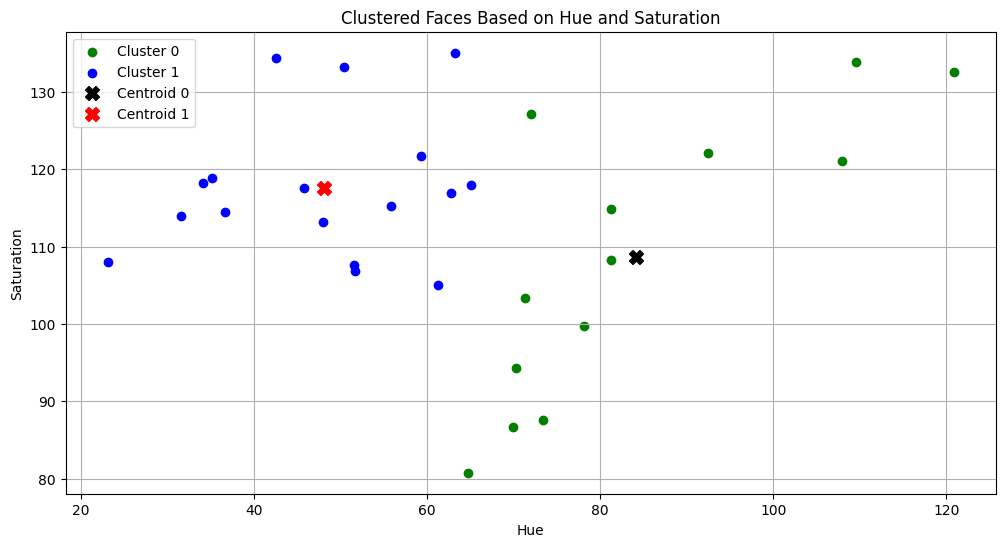

In [10]:
# # Initialize wandb
# wandb.init(project="face-detection", name="face_clustering")

# Convert image to HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hue_saturation = []
face_images = []

# Extract face region features (Hue and Saturation)
for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

# Perform k-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(hue_saturation)

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Scatter plot setup
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:  # Fixed the reference to kmeans.labels_
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

cluster_0_points = np.array(cluster_0_points)
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label="Cluster 0")

cluster_1_points = np.array(cluster_1_points)
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label="Cluster 1")

# Calculate and plot centroids
centroid_0 = np.mean(cluster_0_points, axis=0)
centroid_1 = np.mean(cluster_1_points, axis=0)

plt.scatter(centroid_0[0], centroid_0[1], color='black', marker='X', s=100, label="Centroid 0")
plt.scatter(centroid_1[0], centroid_1[1], color='red', marker='X', s=100, label="Centroid 1")

# Labels and title
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Clustered Faces Based on Hue and Saturation")
plt.legend()
plt.grid(True)

# Save plot for wandb logging
cluster_plot_path = "clustered_faces.png"
plt.savefig(cluster_plot_path)
plt.show()

# Log the hue and saturation values along with cluster labels
table = wandb.Table(columns=["Hue", "Saturation", "Cluster"])
for i in range(len(hue_saturation)):
    table.add_data(hue_saturation[i, 0], hue_saturation[i, 1], int(kmeans.labels_[i]))

# Log findings to wandb
wandb.log({"Hue-Saturation Clusters": table})
wandb.log({"Clustered Faces Plot": wandb.Image(cluster_plot_path)})




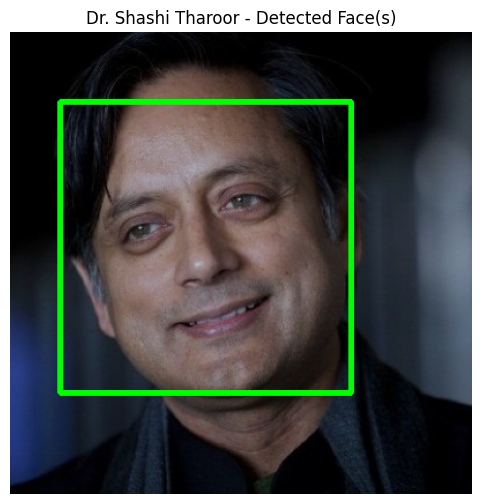

In [11]:
template_img = cv2.imread("/kaggle/input/dataset-classification/Dr_Shashi_Tharoor.jpg")
wandb.init(project="distance_classification_project")
#wandb.init(project="face-detection", name="template_face_detection")
# Convert to grayscale
template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)

# Load the face cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Detect face(s) in the template image
template_faces = face_cascade.detectMultiScale(template_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)

# Convert image to RGB for Matplotlib display
template_img_rgb = cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.figure(figsize=(8, 6))  
plt.imshow(template_img_rgb)  
plt.axis("off")  
plt.title("Dr. Shashi Tharoor - Detected Face(s)")  
plt.show()  

# Save the processed image
output_path = "detected_faces_template.jpg"
cv2.imwrite(output_path, template_img)

# Log detected face coordinates
face_table = wandb.Table(columns=["X", "Y", "Width", "Height"])
for (x, y, w, h) in template_faces:
    face_table.add_data(x, y, w, h)

# Log findings to wandb
wandb.log({"Detected Faces in Template": face_table})
wandb.log({"Detected Faces Image": wandb.Image(output_path)})

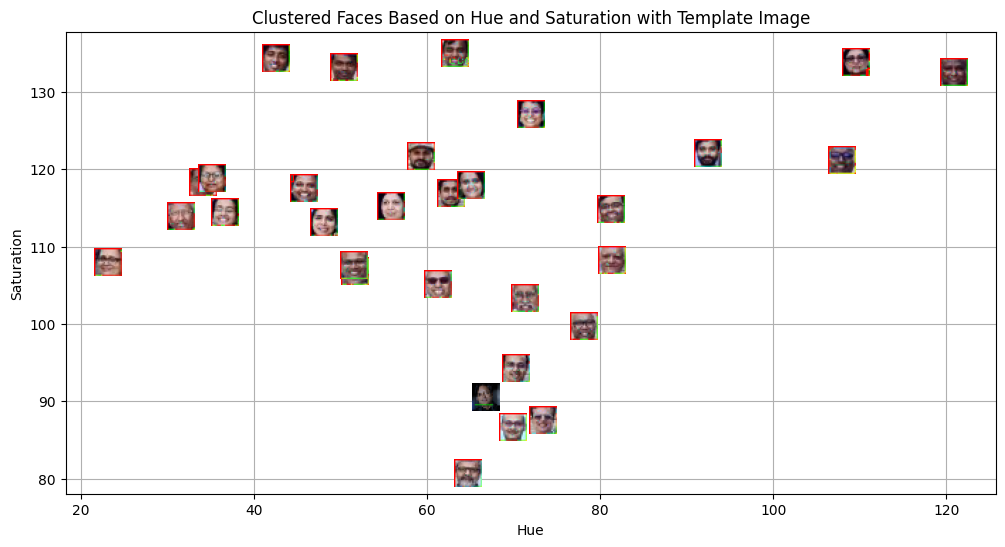

<Figure size 640x480 with 0 Axes>

In [12]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# Extract hue and saturation features from the template image as we did for detected faces.
template_hue = np.mean(template_hsv[:, :, 0])  # Extracting the mean hue
template_saturation = np.mean(template_hsv[:, :, 1])  # Extracting the mean saturation

# Predict the cluster label for the template image and store it in template_label
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
color = 'red' if template_label == 0 else 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

# Put x label
plt.xlabel("Hue")

# Put y label
plt.ylabel("Saturation")

# Put title
plt.title("Clustered Faces Based on Hue and Saturation with Template Image")

# Add grid
plt.grid(True)

# Show plot
plt.show()
plot_path = "clustered_faces_plot.png"
plt.savefig(plot_path)
plt.show()

# Log findings to wandb
wandb.log({
    "Template Hue": template_hue,
    "Template Saturation": template_saturation,
    "Predicted Cluster Label": template_label,
    "Clustered Faces Plot": wandb.Image(plot_path)
})



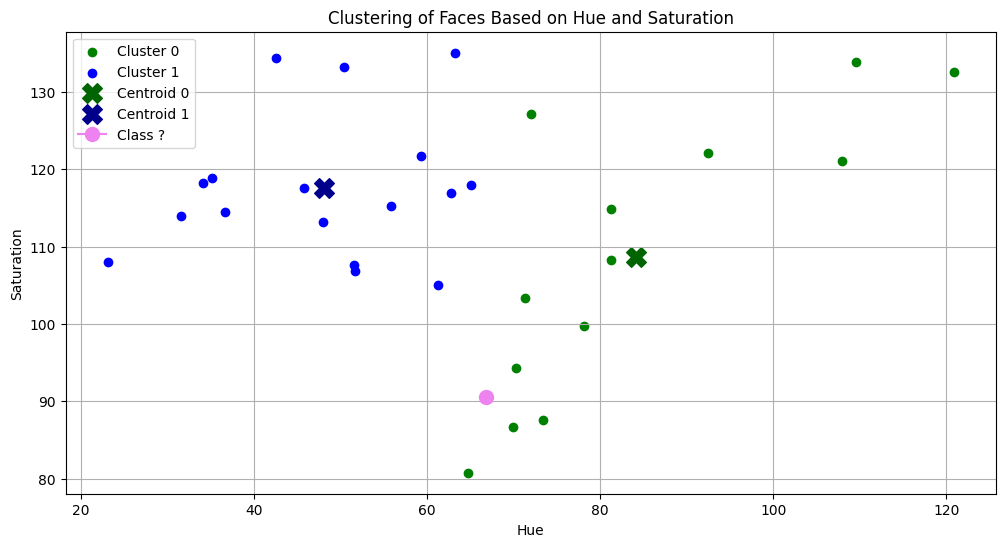

<Figure size 640x480 with 0 Axes>

Detected Faces,▁
Predicted Cluster Label,▁
Template Hue,▁▁
Template Saturation,▁▁
Detected Faces,30
Predicted Cluster Label,0
Template Hue,66.77282
Template Saturation,90.50254


In [13]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

# Convert lists to NumPy arrays for easier manipulation
cluster_0_points = np.array(cluster_0_points)
cluster_1_points = np.array(cluster_1_points)

# Plot points for cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label='Cluster 0')

# Plot points for cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label='Cluster 1')

# Calculate and plot centroids for both clusters
centroid_0 = np.mean(cluster_0_points, axis=0)
centroid_1 = np.mean(cluster_1_points, axis=0)

# Plot centroid for cluster 0
plt.scatter(centroid_0[0], centroid_0[1], color='darkgreen', marker='X', s=200, label='Centroid 0')

# Plot centroid for cluster 1
plt.scatter(centroid_1[0], centroid_1[1], color='darkblue', marker='X', s=200, label='Centroid 1')

# Plot the template hue and saturation as a violet point
plt.plot(template_hue, template_saturation, marker='o', color='violet', markersize=10, label='Class ?')

# Put x label
plt.xlabel("Hue")

# Put y label
plt.ylabel("Saturation")

# Put title
plt.title("Clustering of Faces Based on Hue and Saturation")

# Add a legend
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()

scatter_plot_path = "clustering_scatter_plot.png"
plt.savefig(scatter_plot_path)
plt.show()

# Log findings to wandb
wandb.log({
    "Cluster 0 Centroid": centroid_0.tolist(),
    "Cluster 1 Centroid": centroid_1.tolist(),
    "Template Hue": template_hue,
    "Template Saturation": template_saturation,
    "Clustering Scatter Plot": wandb.Image(scatter_plot_path)
})

# Finish wandb logging
wandb.finish()